# Federated Hierarchical Linear Regression
Here we will demonstrate the utility of federated hierarchical linear regression approach for solving
hierarchical linear regression.

We will use [OSIC Pulmonary Fibrosis Progression](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression) competition, hosted at Kaggle.

## 1. Understanding the task
Pulmonary fibrosis is a disorder with no known cause and no known cure, created by scarring of the lungs. In this competition, we were asked to predict a patient’s severity of decline in lung function. Lung function is assessed based on output from a spirometer, which measures the forced vital capacity (FVC), i.e. the volume of air exhaled.

In medical applications, it is useful to **evaluate a model's confidence in its decisions**. Accordingly, the metric used to rank the teams was designed to reflect **both the accuracy and certainty of each prediction**. It's a modified version of the Laplace Log Likelihood (more details on that later).

Let's explore the data and see what's that all about:

In [69]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

from jax import vmap

In [2]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)

# separate data on subjects 
def make_dictionary(dataset, patient_ids):
    dicts = {}
    for n, id in enumerate(patient_ids):
        df = dataset.loc[dataset.Patient.isin([id])]
        labels = {
            'Age': df.Age,
            'Sex': df.Sex,
            'SmokingStatus': df.SmokingStatus 
        }

        dicts[id] = {'target': df.FVC.values, 'covariates': df.Weeks, 'labels': labels}

    return dicts

fed_data = make_dictionary(train, train.Patient.unique())

train

Patient  Weeks   FVC    Percent  Age   Sex  \
0     ID00007637202177411956430     -4  2315  58.253649   79  Male   
1     ID00007637202177411956430      5  2214  55.712129   79  Male   
2     ID00007637202177411956430      7  2061  51.862104   79  Male   
3     ID00007637202177411956430      9  2144  53.950679   79  Male   
4     ID00007637202177411956430     11  2069  52.063412   79  Male   
...                         ...    ...   ...        ...  ...   ...   
1544  ID00426637202313170790466     13  2712  66.594637   73  Male   
1545  ID00426637202313170790466     19  2978  73.126412   73  Male   
1546  ID00426637202313170790466     31  2908  71.407524   73  Male   
1547  ID00426637202313170790466     43  2975  73.052745   73  Male   
1548  ID00426637202313170790466     59  2774  68.117081   73  Male   

     SmokingStatus  
0        Ex-smoker  
1        Ex-smoker  
2        Ex-smoker  
3        Ex-smoker  
4        Ex-smoker  
...            ...  
1544  Never smoked  
1545  Never smoked  
1546  Never smoked  
1547  Never smoked  
1548  Never smoked  

[1549 rows x 7 columns]

In the dataset, we were provided with a baseline chest CT scan and associated clinical information for a set of patients. A patient has an image acquired at time Week = 0 and has numerous follow up visits over the course of approximately 1-2 years, at which time their FVC is measured. For this tutorial, I will use only the Patient ID, the weeks and the FVC measurements, discarding all the rest. Using only these columns enabled our team to achieve a competitive score, which shows the power of Bayesian hierarchical linear regression models especially when gauging uncertainty is an important part of the problem.

Since this is real medical data, the relative timing of FVC measurements varies widely, as shown in the 3 sample patients below:

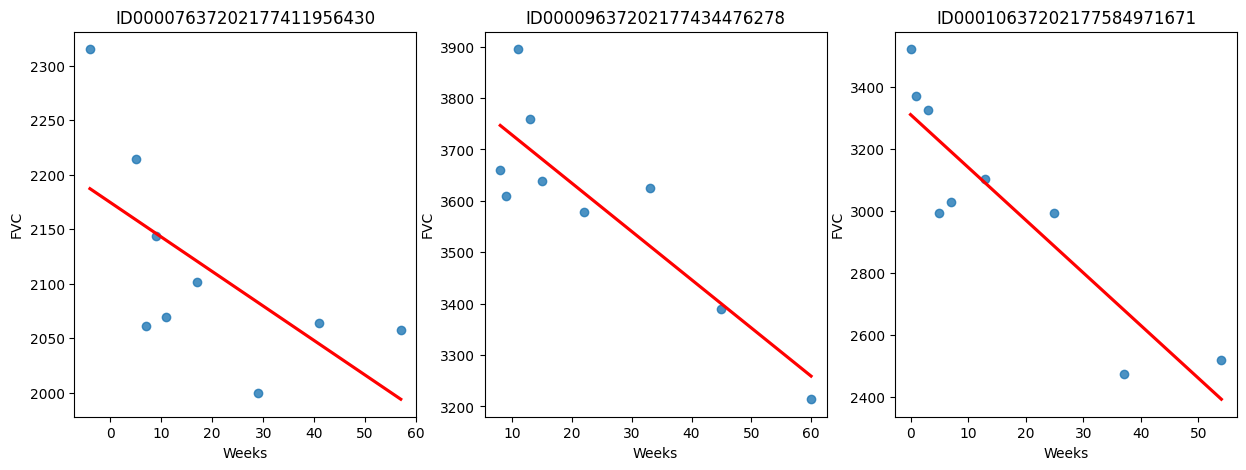

In [3]:
def chart_patient(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    ax.set_title(patient_id)
    sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient("ID00007637202177411956430", axes[0])
chart_patient("ID00009637202177434476278", axes[1])
chart_patient("ID00010637202177584971671", axes[2])

On average, each of the 176 provided patients made 9 visits, when FVC was measured. The visits happened in specific weeks in the [-12, 133] interval. The decline in lung capacity is very clear. We see, though, they are very different from patient to patient.

We were are asked to predict every patient's FVC measurement for every possible week in the [-12, 133] interval, and the confidence for each prediction. In other words: we were asked fill a matrix like the one below, and provide a confidence score for each prediction:

<img src="https://i.ibb.co/0Z9kW8H/matrix-completion.jpg" alt="drawing" width="600"/>

## 2. Modelling: Bayesian Hierarchical Linear Regression with Partial Pooling
The simplest possible linear regression, not hierarchical, would assume all FVC decline curves have the same $\alpha$ and $\beta$. That's the **pooled model**. In the other extreme, we could assume a model where each patient has a personalized FVC decline curve, and **these curves are completely unrelated**. That's the **unpooled model**, where each patient has completely separate regressions.

Here, I'll use the middle ground: **Partial pooling**. Specifically, I'll assume that while $\alpha$'s and $\beta$'s are different for each patient as in the unpooled case, **the coefficients all share similarity**. We can model this by assuming that each individual coefficient comes from a common group distribution. The image below represents this model graphically:

<img src="https://i.ibb.co/H7NgBfR/Artboard-2-2x-100.jpg" alt="drawing" width="600"/>

Mathematically, the model is described by the following equations:

\begin{align}
\mu_{\alpha} &\sim \mathcal{N}(0, 500) \\
\sigma_{\alpha} &\sim |\mathcal{N}(0, 100)| \\
\mu_{\beta} &\sim \mathcal{N}(0, 3) \\
\sigma_{\beta} &\sim |\mathcal{N}(0, 3)| \\
\alpha_i &\sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}) \\
\beta_i &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}) \\
\sigma &\sim \mathcal{N}(0, 100) \\
FVC_{ij} &\sim \mathcal{N}(\alpha_i + t \beta_i, \sigma)
\end{align}

where *t* is the time in weeks. Those are very uninformative priors, but that's ok: our model will converge!

Implementing this model in NumPyro is pretty straightforward:

In [70]:
import numpyro
numpyro.set_platform('cpu')
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random, vmap
from functools import partial

In [121]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
from numpyro.distributions.transforms import biject_to

def global_model(Weeks, FVC_obs=None, **kwargs):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    u_α = numpyro.sample('u_α', dist.Gamma(2., 1.))
    σ_α = numpyro.deterministic("σ_α", jnp.sqrt(1e5 / u_α))

    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    u_β = numpyro.sample('u_β', dist.Gamma(2., 1.))
    σ_β = numpyro.deterministic("σ_β", jnp.sqrt(5 / u_β))

    u = numpyro.sample('u', dist.Gamma(.5, 1.))

    output_dict = {
        "μ_α": μ_α,
        "μ_β": μ_β,
        "σ_α": σ_α,
        "σ_β": σ_β,
        "u": u,
        "Weeks": Weeks,
        "FVC_obs": FVC_obs,
    }

    output_dict.update(kwargs)

    return output_dict

def local_model(input_dict):
    μ_α = input_dict["μ_α"]
    μ_β = input_dict["μ_β"]
    σ_α = input_dict["σ_α"] 
    σ_β = input_dict["σ_β"]
    u = input_dict["u"]

    Weeks = input_dict["Weeks"]
    FVC_obs = input_dict["FVC_obs"]
    mask = input_dict.pop("mask", None)
    subsample_size = input_dict.pop("subsample_size", None)

    n_data, n_patients = Weeks.shape
    with numpyro.plate("patients", n_patients, subsample_size=subsample_size):

        covariates = numpyro.subsample(Weeks, event_dim=0)
        if FVC_obs is not None:
            obs = numpyro.subsample(FVC_obs, event_dim=0)
        else:
            obs = None

        v = numpyro.sample("v", dist.Gamma(.5, 1.))
        σ = numpyro.deterministic("σ", jnp.sqrt(1e4 * u / v))
        α = numpyro.sample("α", dist.Normal(μ_α, σ * σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ * σ_β))
        
        loc = α + β * covariates
        with numpyro.plate("data", n_data):
            if mask is None:
                numpyro.sample("obs", dist.Normal(loc, σ), obs=obs)
            else:
                m = numpyro.subsample(mask, event_dim=0)
                numpyro.sample("obs", dist.Normal(loc, σ).mask(m), obs=obs)

def model(*args, **kwargs):
    local_model(global_model(*args, **kwargs)) 

def normal_post(name, shape=(), idx=None):
    loc = numpyro.param(
        name + '.loc', 
        lambda rng_key: dist.Uniform(-2, 2)(rng_key=rng_key,sample_shape=shape)
    )
    scale = numpyro.param(name + '.scale', jnp.ones(shape)/10, constraint=dist.constraints.positive)

    if idx is not None:
        return dist.Normal(loc[idx], scale[idx])
    else:
        return dist.Normal(loc, scale)

def lognormal_post(name, shape=(), idx=None):
    loc = numpyro.param(
        name + '.loc', 
        lambda rng_key: dist.Uniform(-2, 2)(rng_key=rng_key, sample_shape=shape)
    )
    scale = numpyro.param(name + '.scale', jnp.ones(shape)/10, constraint=dist.constraints.positive)

    if idx is not None:
        site_fn = dist.Normal(loc[idx], scale[idx])
    else:
        site_fn = dist.Normal(loc, scale)

    transform = biject_to(dist.constraints.positive)
    return dist.TransformedDistribution(site_fn, transform)

def exact_bayes_reg(y, X, a_0=.5, b_0=1., mask=None, Λ_0=None, μ_0=None):
    if jnp.ndim(X) > 1:
        _X = jnp.pad(X, ((0, 0), (1, 0)), constant_values=1.)
    else:
        _X = jnp.pad(jnp.expand_dims(X, -1), ((0, 0), (1, 0)), constant_values=1.)

    _X = jnp.expand_dims(mask, -1) * _X if mask is not None else _X
    Λ_0 = jnp.identity(_X.shape[-1]) if Λ_0 is None else Λ_0
    μ_0 = jnp.zeros(_X.shape[-1]) if μ_0 is None else μ_0

    Λₙ = Λ_0 + _X.T @ _X
    Σₙ = jnp.linalg.solve(Λₙ, jnp.identity(_X.shape[-1]))

    μₙ = Σₙ @ (_X.T @ y + Λ_0 @ μ_0)

    aₙ = a_0 + mask.sum()/2 if mask is not None else a_0 + _X.shape[0]/2.
    bₙ = b_0 + (jnp.inner(y, y) + μ_0 @ Λ_0 @ μ_0 - μₙ @ Λₙ @ μₙ )/2

    return μₙ, Σₙ, aₙ, bₙ

def guide(Weeks, FVC_obs=None, subsample_size=None, **kwargs):

    mask = kwargs.pop("mask", None)

    μ_α = numpyro.sample("μ_α", normal_post("μ_α"))
    u_α = numpyro.sample('u_α', lognormal_post('u_α'))
    σ_α_sqr_inv = u_α / 1e5

    μ_β = numpyro.sample("μ_β", normal_post("μ_β"))
    u_β = numpyro.sample('u_β', lognormal_post('u_β'))
    σ_β_sqr_inv = u_β / 5

    Λ_0 = jnp.diag(jnp.array([σ_α_sqr_inv, σ_β_sqr_inv]))
    μ_0 = jnp.array([μ_α, μ_β])

    _, n_patients = Weeks.shape

    u = numpyro.sample('u', lognormal_post('u'))
    b_0 = 1e4 * u

    exact_b = lambda x, y, z :exact_bayes_reg(x, y, mask=z, Λ_0=Λ_0, μ_0=μ_0, b_0=b_0)

    with numpyro.plate("patients", n_patients, subsample_size=subsample_size) as idx:
        X = numpyro.subsample(Weeks, event_dim=0)
        y = numpyro.subsample(FVC_obs, event_dim=0) if FVC_obs is not None else None
        m = numpyro.subsample(mask, event_dim=0) if mask is not None else None

        μₙ, Σₙ, aₙ, bₙ = vmap(exact_b)(y.T, X.T, m.T)
        
        v = numpyro.sample("v", dist.Gamma(aₙ, bₙ/b_0))
        σ_sqr = b_0/v

        cov_mat = jnp.expand_dims(σ_sqr, (-1, -2)) * Σₙ
        z = numpyro.sample('z', dist.MultivariateNormal(μₙ, covariance_matrix=cov_mat), infer={"is_auxiliary": True})

        loc_β = (z[:, 1] - μ_β) / jnp.sqrt(σ_β_sqr_inv * v / b_0)

        _β = numpyro.sample('β_decentered', dist.Delta(loc_β))
        loc_α = (z[:, 0] - μ_α) / jnp.sqrt(σ_α_sqr_inv * v / b_0 )
        _α = numpyro.sample('α_decentered', dist.Delta(loc_α))
        
reparam_config = {
    "α": LocScaleReparam(0),
    "β": LocScaleReparam(0)
}

reparam_model = reparam(model, config=reparam_config)

In [108]:
from jax import vmap
μₙ, Σₙ, aₙ, bₙ = vmap(exact_bayes_reg)(FVC_obs.T, weeks.T, mask=mask.T)
print(μₙ[0], Σₙ[0], aₙ[0], bₙ[0])

[1767.4578       7.8512874] [[ 0.1871502  -0.00506687]
 [-0.00506687  0.00029459]] 5.0 1943737.0


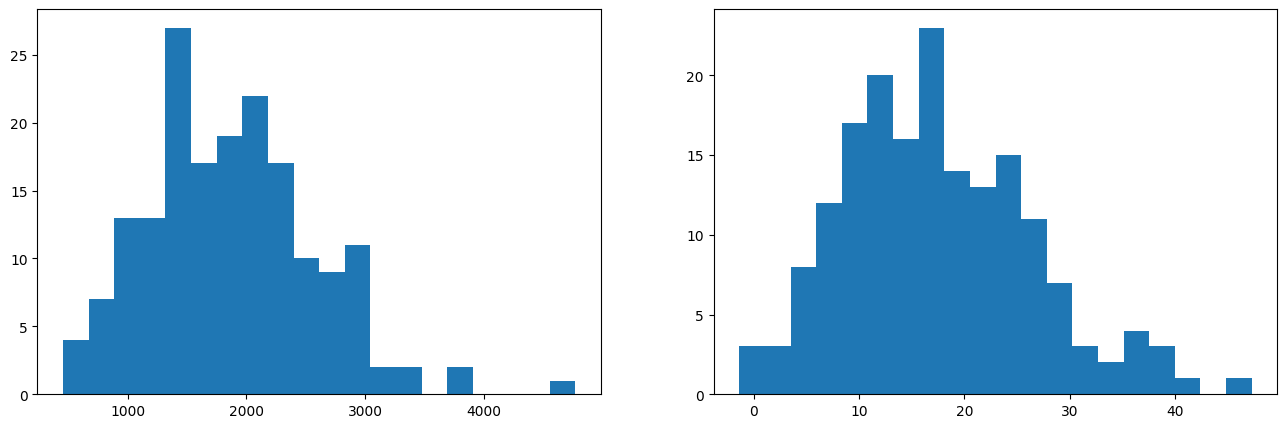

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].hist(μₙ[:, 0], bins=20);
axes[1].hist(μₙ[:, 1], bins=20);

That's all for modelling!

## 3. Fitting the model
A great achievement of Probabilistic Programming Languages such as NumPyro is to decouple model specification and inference. After specifying my generative model, with priors, condition statements and data likelihood, I can leave the hard work to NumPyro's inference engine. 

Calling it requires just a few lines. Before we do it, let's add a numerical Patient ID for each patient code. That can be easily done with scikit-learn's LabelEncoder:

In [93]:
weeks = jnp.arange(train.Weeks.min(), train.Weeks.max() + 1)
df = pd.DataFrame(index=weeks, columns=range(len(fed_data)))

weeks = jnp.broadcast_to(weeks[:, None], (len(weeks), len(fed_data)))
weeks.shape

patient_encoder = dict([(idx, i) for i, idx in enumerate(train["Patient"].unique())])
train["patient_code"] = np.array([patient_encoder[idx] for idx in train["Patient"].values])

for id in fed_data:
    df.loc[fed_data[id]['covariates'].values, patient_encoder[id]] = fed_data[id]['target']

FVC_obs = df.astype(float).values
mask = ~jnp.isnan(FVC_obs)
FVC_obs = jnp.nan_to_num(FVC_obs)

Now, calling NumPyro's inference engine:

In [94]:
nuts_kernel = NUTS(reparam_model)

mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, weeks, FVC_obs=FVC_obs, mask=mask)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [03:10<00:00, 15.76it/s, 511 steps of size 9.01e-03. acc. prob=0.95] 


## 4. Checking the model
### 4.1. Inspecting the learned parameters
First, let's inspect the parameters learned. To do that, I will use [ArviZ](https://arviz-devs.github.io/arviz/), which perfectly integrates with NumPyro:

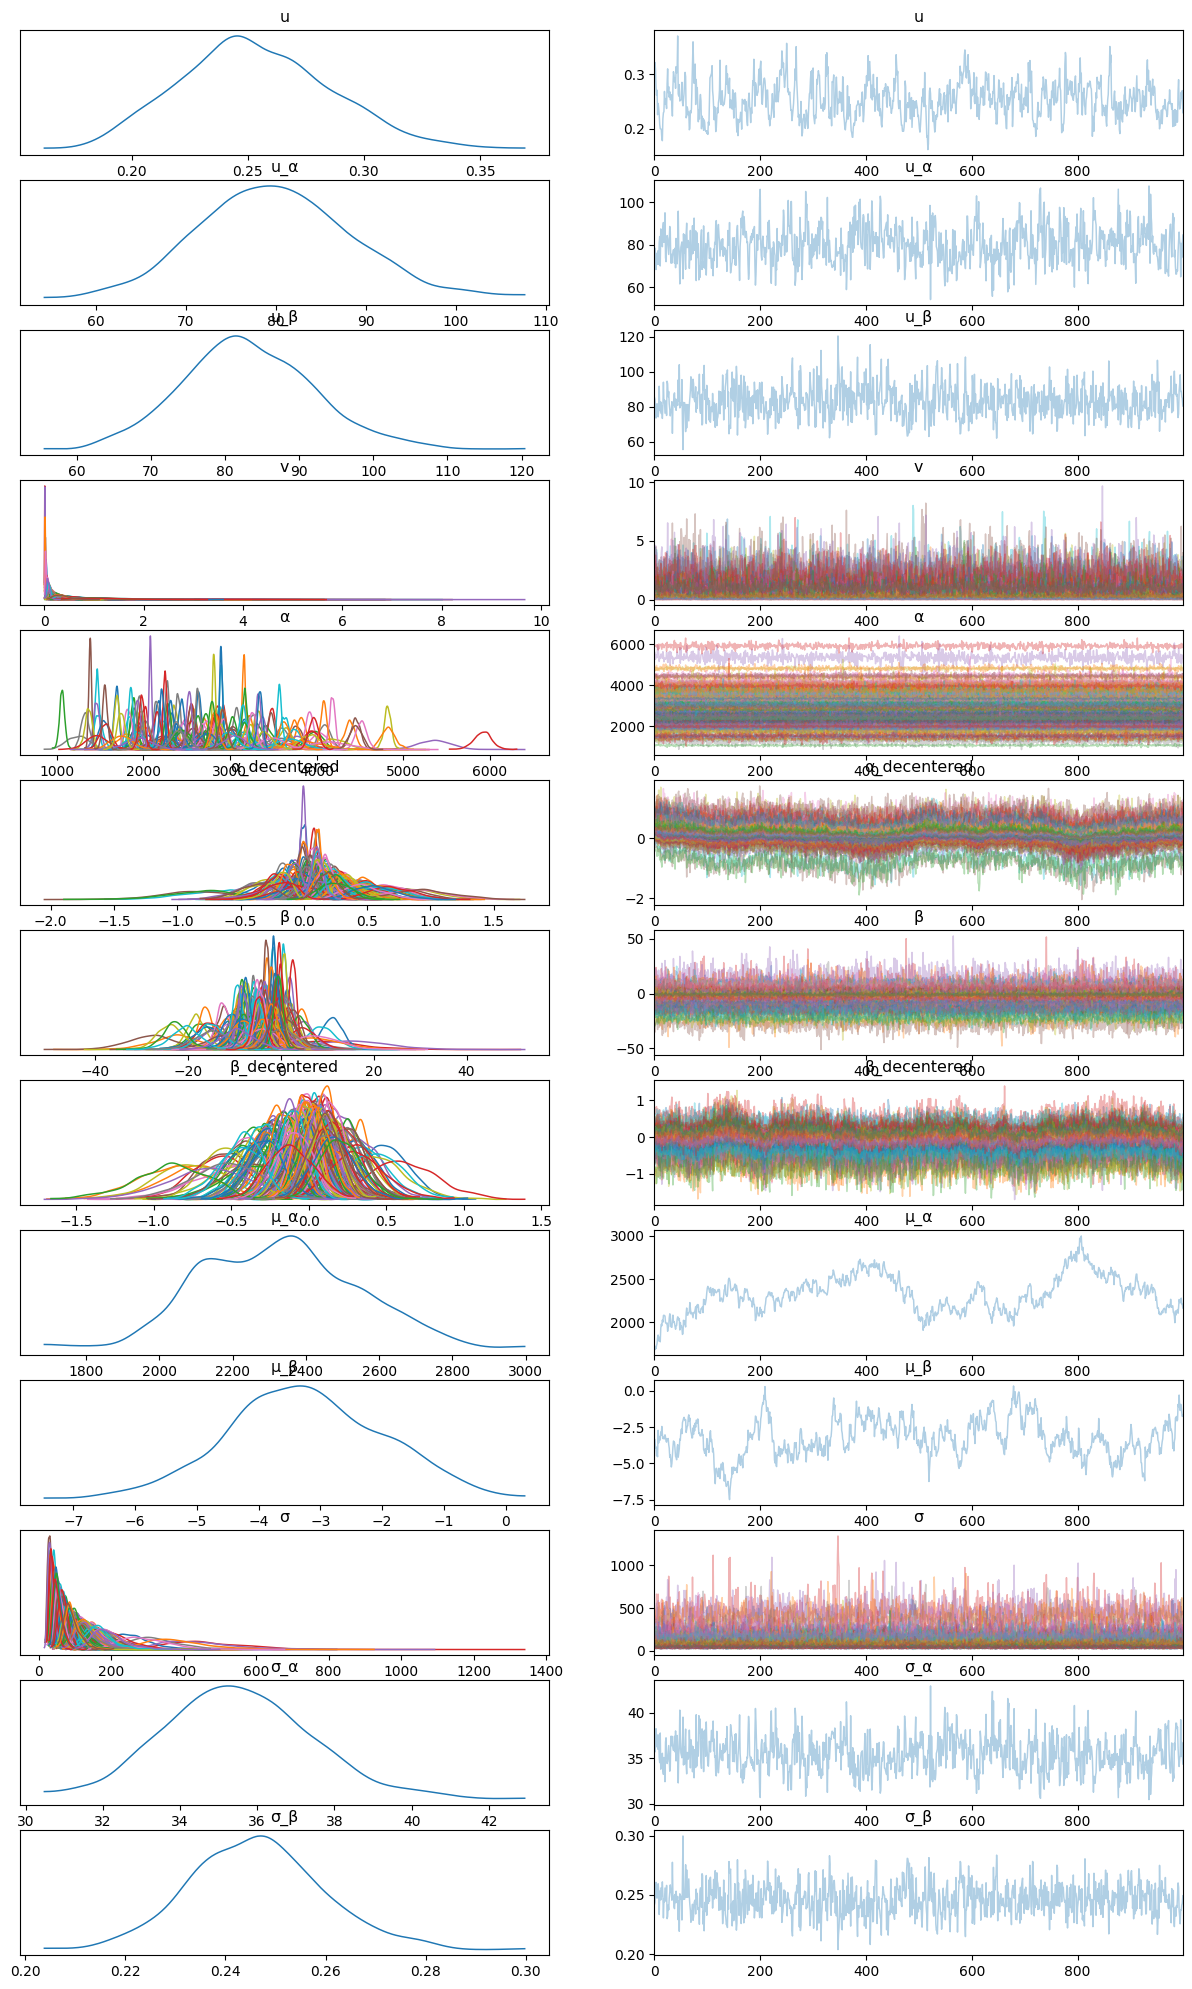

In [95]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));

# Stochastic variational inference



In [122]:
from numpyro.infer import SVI, TraceGraph_ELBO, TraceMeanField_ELBO, Predictive
import optax

optim = optax.adabelief(learning_rate=1e-3, eps=1e-8, eps_root=1e-8)
loss = TraceGraph_ELBO(num_particles=20)
svi = SVI(reparam_model, guide, optim, loss)

rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, 20000, weeks, FVC_obs=FVC_obs, mask=mask, subsample_size=10)

pred = Predictive(guide, params=svi_res.params, num_samples=1000)
rng_key, _rng_key = random.split(rng_key)
svi_samples1 = pred(_rng_key, weeks, FVC_obs=FVC_obs, mask=mask)

pred = Predictive(reparam_model, posterior_samples=svi_samples1)
rng_key, _rng_key = random.split(rng_key)
svi_samples1.update(pred(_rng_key, weeks, FVC_obs=FVC_obs, mask=mask))

100%|██████████| 20000/20000 [00:28<00:00, 713.84it/s, init loss: 265801297085902067073024.0000, avg. loss [19001-20000]: 306805346714011788378112.0000]


In [97]:
from numpyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoSemiDAIS

auto_guide = AutoMultivariateNormal(reparam_model)
svi = SVI(reparam_model, auto_guide, optim, loss)

rng_key, _rng_key = random.split(rng_key)
svi_res = svi.run(_rng_key, 20000, weeks, FVC_obs=FVC_obs, mask=mask)

pred = Predictive(auto_guide, params=svi_res.params, num_samples=1000)
rng_key, _rng_key = random.split(rng_key)
svi_samples2 = pred(_rng_key, weeks, FVC_obs=FVC_obs, mask=mask)

pred = Predictive(reparam_model, posterior_samples=svi_samples2)
rng_key, _rng_key = random.split(rng_key)
svi_samples2.update(pred(_rng_key, weeks, FVC_obs=FVC_obs, mask=mask))

100%|██████████| 20000/20000 [03:11<00:00, 104.25it/s, init loss: 229130960.0000, avg. loss [19001-20000]: 11394.6230]


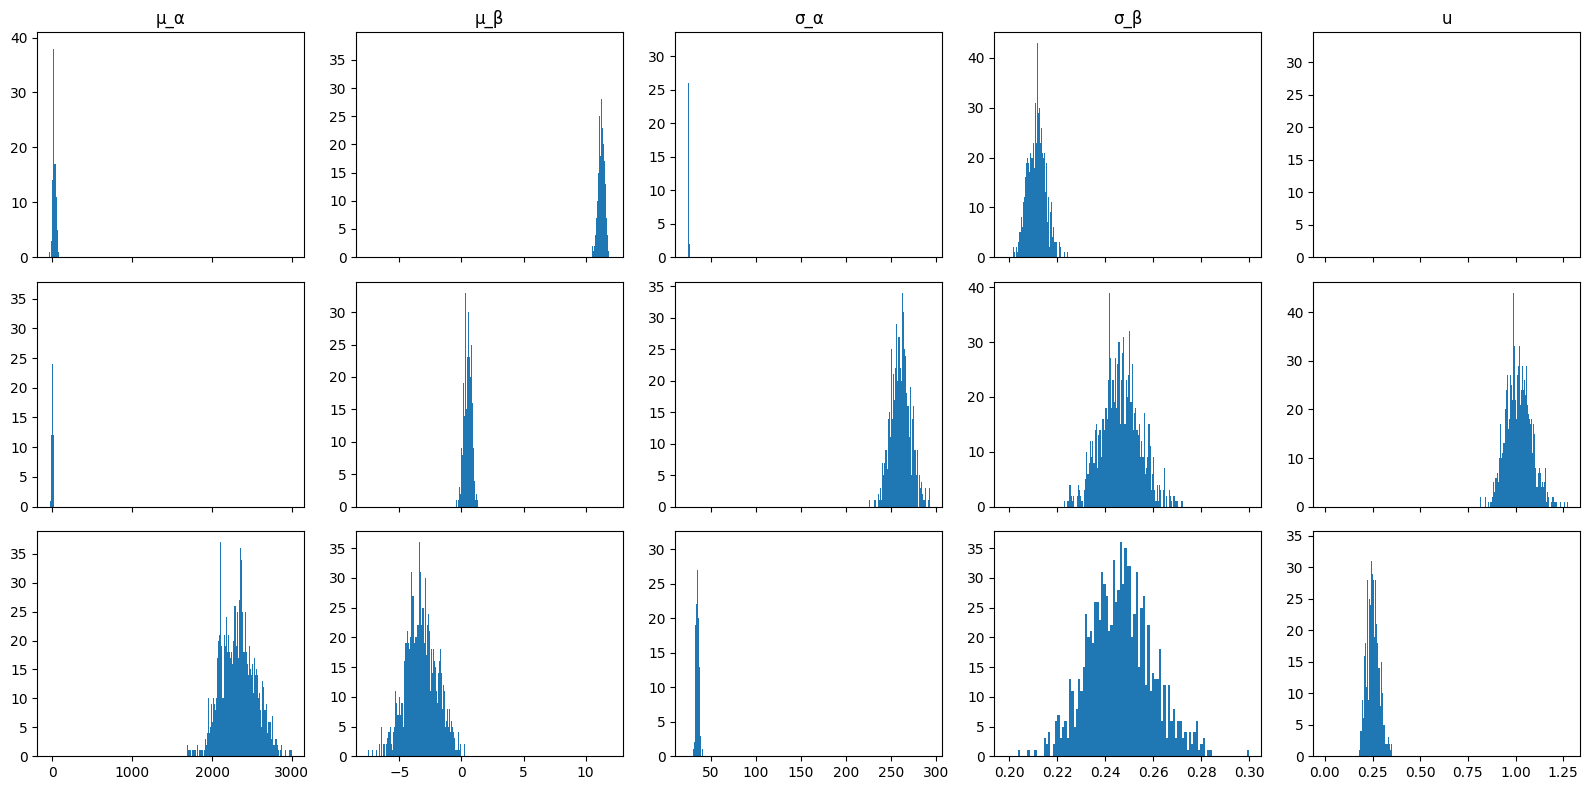

In [98]:
fig, axes = plt.subplots(3, 5, figsize=(16, 8), sharex='col')
for i, name in enumerate(['μ_α', 'μ_β', 'σ_α', 'σ_β', 'u']):
    axes[0, i].hist(svi_samples1[name], bins=100);
    axes[1, i].hist(svi_samples2[name], bins=100);
    axes[2, i].hist(posterior_samples[name], bins=100);

    axes[0, i].set_title(name)

fig.tight_layout()

# Federated variational inference

In [ ]:
# from feds import FedClient

# def map_data_to_clients(data):
#     for key, value in data.items():
#         data[key] = FedClient(value['X'], value['y'], labels=value['labels'])

Looks like our model learned personalized alphas and betas for each patient!

### 4.2. Visualizing FVC decline curves for some patients
Now, let's visually inspect FVC decline curves predicted by our model. We will completely fill in the FVC table, predicting all missing values. The first step is to create a table to fill:

In [ ]:
def create_prediction_template(unique_patient_df, weeks_series):
    unique_patient_df["_temp"] = True
    weeks = pd.DataFrame(weeks_series, columns=["Weeks"])
    weeks["_temp"] = True
    return unique_patient_df.merge(weeks, on="_temp").drop(["_temp"], axis=1)

In [ ]:
patients = train[["Patient", "patient_code"]].drop_duplicates()
start_week_number = -12
end_week_number = 134
predict_weeks = pd.Series(np.arange(start_week_number, end_week_number))
pred_template = create_prediction_template(patients, predict_weeks)

Predicting the missing values in the FVC table and confidence (sigma) for each value becomes really easy:

In [ ]:
patient_code = pred_template["patient_code"].values
Weeks = pred_template["Weeks"].values
predictive = Predictive(model, posterior_samples, return_sites=["σ", "obs"])
samples_predictive = predictive(random.PRNGKey(0), patient_code, Weeks, None)

Let's now put the predictions together with the true values, to visualize them:

In [ ]:
df = pred_template.copy()
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})
df.head()

Patient  patient_code  Weeks     FVC_pred       sigma  \
0  ID00007637202177411956430             0    -12  2218.195801  112.354950   
1  ID00007637202177411956430             0    -11  2214.010742  112.274025   
2  ID00007637202177411956430             0    -10  2206.214111  107.603912   
3  ID00007637202177411956430             0     -9  2208.545166  108.869774   
4  ID00007637202177411956430             0     -8  2209.743164  109.044518   

       FVC_inf      FVC_sup  FVC_true  
0  2105.840820  2330.550781       NaN  
1  2101.736816  2326.284668       NaN  
2  2098.610107  2313.818115       NaN  
3  2099.675293  2317.415039       NaN  
4  2100.698730  2318.787598       NaN

Finally, let's see our predictions for 3 patients:

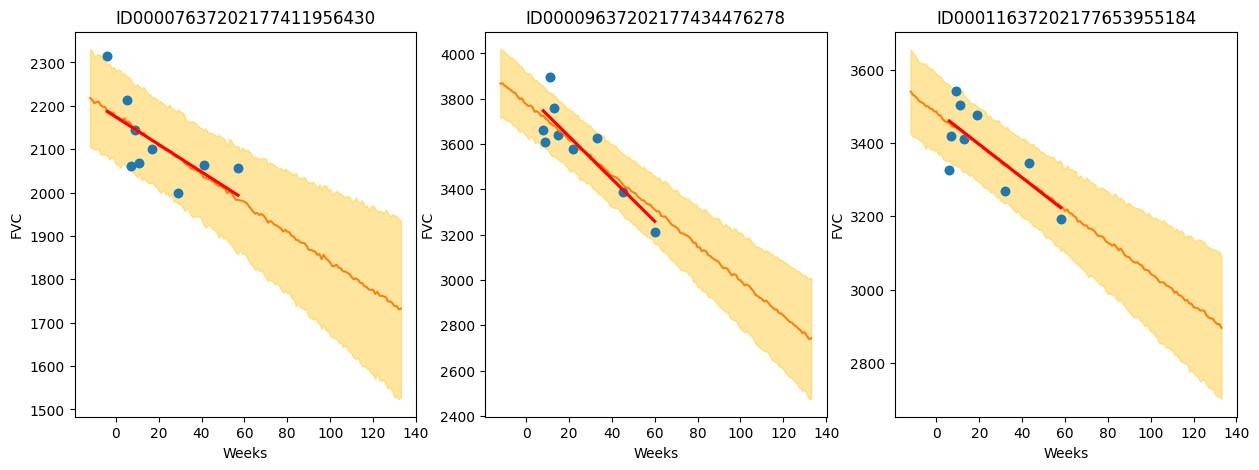

In [ ]:
def chart_patient_with_predictions(patient_id, ax):
    data = df[df["Patient"] == patient_id]
    x = data["Weeks"]
    ax.set_title(patient_id)
    ax.plot(x, data["FVC_true"], "o")
    ax.plot(x, data["FVC_pred"])
    ax = sns.regplot(x=x, y=data["FVC_true"], ax=ax, ci=None, line_kws={"color": "red"})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"], alpha=0.5, color="#ffcd3c")
    ax.set_ylabel("FVC")


f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient_with_predictions("ID00007637202177411956430", axes[0])
chart_patient_with_predictions("ID00009637202177434476278", axes[1])
chart_patient_with_predictions("ID00011637202177653955184", axes[2])

The results are exactly what we expected to see! Highlight observations:

- The model adequately learned Bayesian Linear Regressions! The orange line (learned predicted FVC mean) is very inline with the red line (deterministic linear regression). But most important: it learned to predict uncertainty, showed in the light orange region (one sigma above and below the mean FVC line)
- The model predicts a higher uncertainty where the data points are more disperse (1st and 3rd patients). Conversely, where the points are closely grouped together (2nd patient), the model predicts a higher confidence (narrower light orange region)
- Finally, in all patients, we can see that the uncertainty grows as the look more into the future: the light orange region widens as the # of weeks grow!

### 4.3. Computing the modified Laplace Log Likelihood and RMSE

As mentioned earlier, the competition was evaluated on a modified version of the Laplace Log Likelihood. In medical applications, it is useful to evaluate a model's confidence in its decisions. Accordingly, the metric is designed to reflect both the accuracy and certainty of each prediction.

For each true FVC measurement, we predicted both an FVC and a confidence measure (standard deviation $\sigma$). The metric was computed as:

\begin{align}
\sigma_{clipped} &= max(\sigma, 70) \\
\delta &= min(|FVC_{true} - FVC_{pred}|, 1000) \\
metric &= -\dfrac{\sqrt{2}\delta}{\sigma_{clipped}} - \ln(\sqrt{2} \sigma_{clipped})
\end{align}

The error was thresholded at 1000 ml to avoid large errors adversely penalizing results, while the confidence values were clipped at 70 ml to reflect the approximate measurement uncertainty in FVC. The final score was calculated by averaging the metric across all (Patient, Week) pairs. Note that metric values will be negative and higher is better.

Next, we calculate the metric and RMSE:

In [ ]:
y = df.dropna()
rmse = ((y["FVC_pred"] - y["FVC_true"]) ** 2).mean() ** (1 / 2)
print(f"RMSE: {rmse:.1f} ml")

sigma_c = y["sigma"].values
sigma_c[sigma_c < 70] = 70
delta = (y["FVC_pred"] - y["FVC_true"]).abs()
delta[delta > 1000] = 1000
lll = -np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f"Laplace Log Likelihood: {lll.mean():.4f}")

RMSE: 130.0 ml
Laplace Log Likelihood: -6.0254


What do these numbers mean? It means if you adopted this approach, you would **outperform most of the public solutions** in the competition. Curiously, the vast majority of public solutions adopt a standard deterministic Neural Network, modelling uncertainty through a quantile loss. **Most of the people still adopt a frequentist approach**.

**Uncertainty** for single predictions becomes more and more important in machine learning and is often a requirement. **Especially when the consequences of a wrong prediction are high**, we need to know what the probability distribution of an individual prediction is. For perspective, Kaggle just launched a new competition sponsored by Lyft, to build motion prediction models for self-driving vehicles. "We ask that you predict a few trajectories for every agent **and provide a confidence score for each of them**."

## 5. Add layer to model hierarchy: Smoking Status

We can extend the model by including the column `SmokingStatus` as a pooling level, where model parameters will be partially pooled by the groups "Never smoked", "Ex-smoker", and "Currently smokes".  To do this, we need to:

1. Encode the `SmokingStatus` column
2. Map patient encoding to smoking status encodings
3. Refine and retrain the model with the additional hierarchy

In [ ]:
train["SmokingStatus"].value_counts()

Ex-smoker           1038
Never smoked         429
Currently smokes      82
Name: SmokingStatus, dtype: int64

In [ ]:
patient_code = train["patient_code"].values
Weeks = train["Weeks"].values

In [ ]:
smoking_status_encoder = dict([(idx, i) for i, idx in enumerate(train["SmokingStatus"].unique())])
train["smoking_status_code"] = np.array([smoking_status_encoder[idx] for idx in train["SmokingStatus"].values])

smoking_status_code = train["smoking_status_code"].values
smoking_status_code

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
map_patient_to_smoking_status = (
    train[["patient_code", "smoking_status_code"]]
    .drop_duplicates()
    .set_index("patient_code", verify_integrity=True)
    .sort_index()["smoking_status_code"]
    .values
)

map_patient_to_smoking_status

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0,
       2, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1])

In [ ]:
def model_smoking_hierarchy(
    patient_code, Weeks, map_patient_to_smoking_status, FVC_obs=None
):
    μ_α_global = numpyro.sample("μ_α_global", dist.Normal(0.0, 500.0))
    σ_α_global = numpyro.sample("σ_α_global", dist.HalfNormal(100.0))
    μ_β_global = numpyro.sample("μ_β_global", dist.Normal(0.0, 3.0))
    σ_β_global = numpyro.sample("σ_β_global", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))
    n_smoking_statuses = len(np.unique(map_patient_to_smoking_status))

    with numpyro.plate("plate_smoking_status", n_smoking_statuses):
        μ_α_smoking_status = numpyro.sample(
            "μ_α_smoking_status", dist.Normal(μ_α_global, σ_α_global)
        )
        μ_β_smoking_status = numpyro.sample(
            "μ_β_smoking_status", dist.Normal(μ_β_global, σ_β_global)
        )

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample(
            "α",
            dist.Normal(μ_α_smoking_status[map_patient_to_smoking_status], σ_α_global),
        )
        β = numpyro.sample(
            "β",
            dist.Normal(μ_β_smoking_status[map_patient_to_smoking_status], σ_β_global),
        )

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

In [ ]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {
    "μ_α_smoking_status": LocScaleReparam(0),
    "μ_β_smoking_status": LocScaleReparam(0),
    "α": LocScaleReparam(0),
    "β": LocScaleReparam(0),
}
reparam_model_smoking_hierarchy = reparam(
    model_smoking_hierarchy, config=reparam_config
)

In [ ]:
nuts_kernel = NUTS(reparam_model_smoking_hierarchy, target_accept_prob=0.97)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=5000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, patient_code, Weeks, map_patient_to_smoking_status, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 7000/7000 [02:12<00:00, 52.72it/s, 1023 steps of size 5.29e-03. acc. prob=0.97]


### 5.1. Inspect the learned parameters

/home/dima/.conda/envs/fedbmr/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 1549 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -9996.16    78.69
p_loo      291.19        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1407   90.8%
 (0.5, 0.7]   (ok)        101    6.5%
   (0.7, 1]   (bad)        38    2.5%
   (1, Inf)   (very bad)    3    0.2%

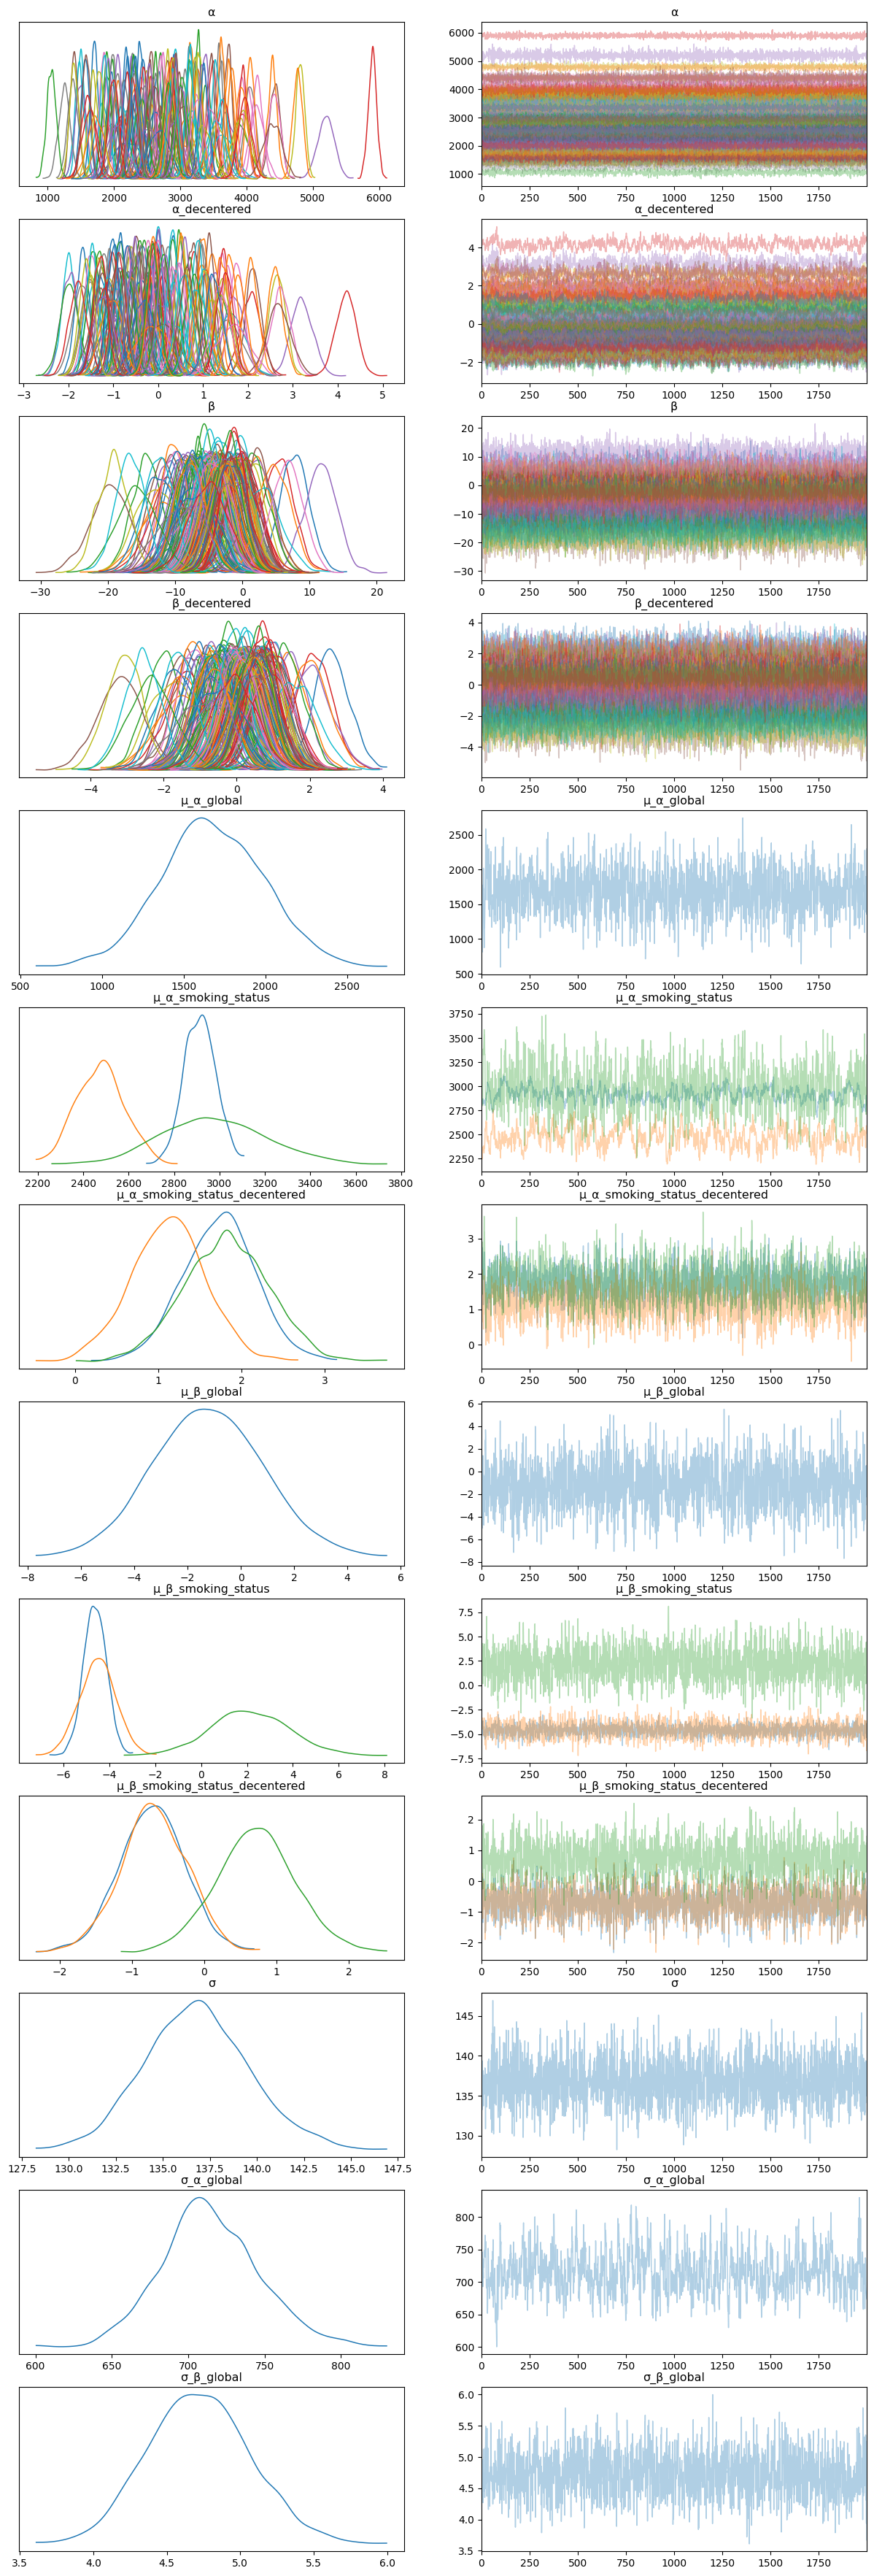

In [ ]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 45));
az.loo(data)

#### Smoking Status distributions

Adding a legend for the smoking status distributions to help interpret the model results for that level.

In [ ]:
# Check the label code for each SmokingStatus
smoking_status_encoder

{'Ex-smoker': 0, 'Never smoked': 1, 'Currently smokes': 2}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


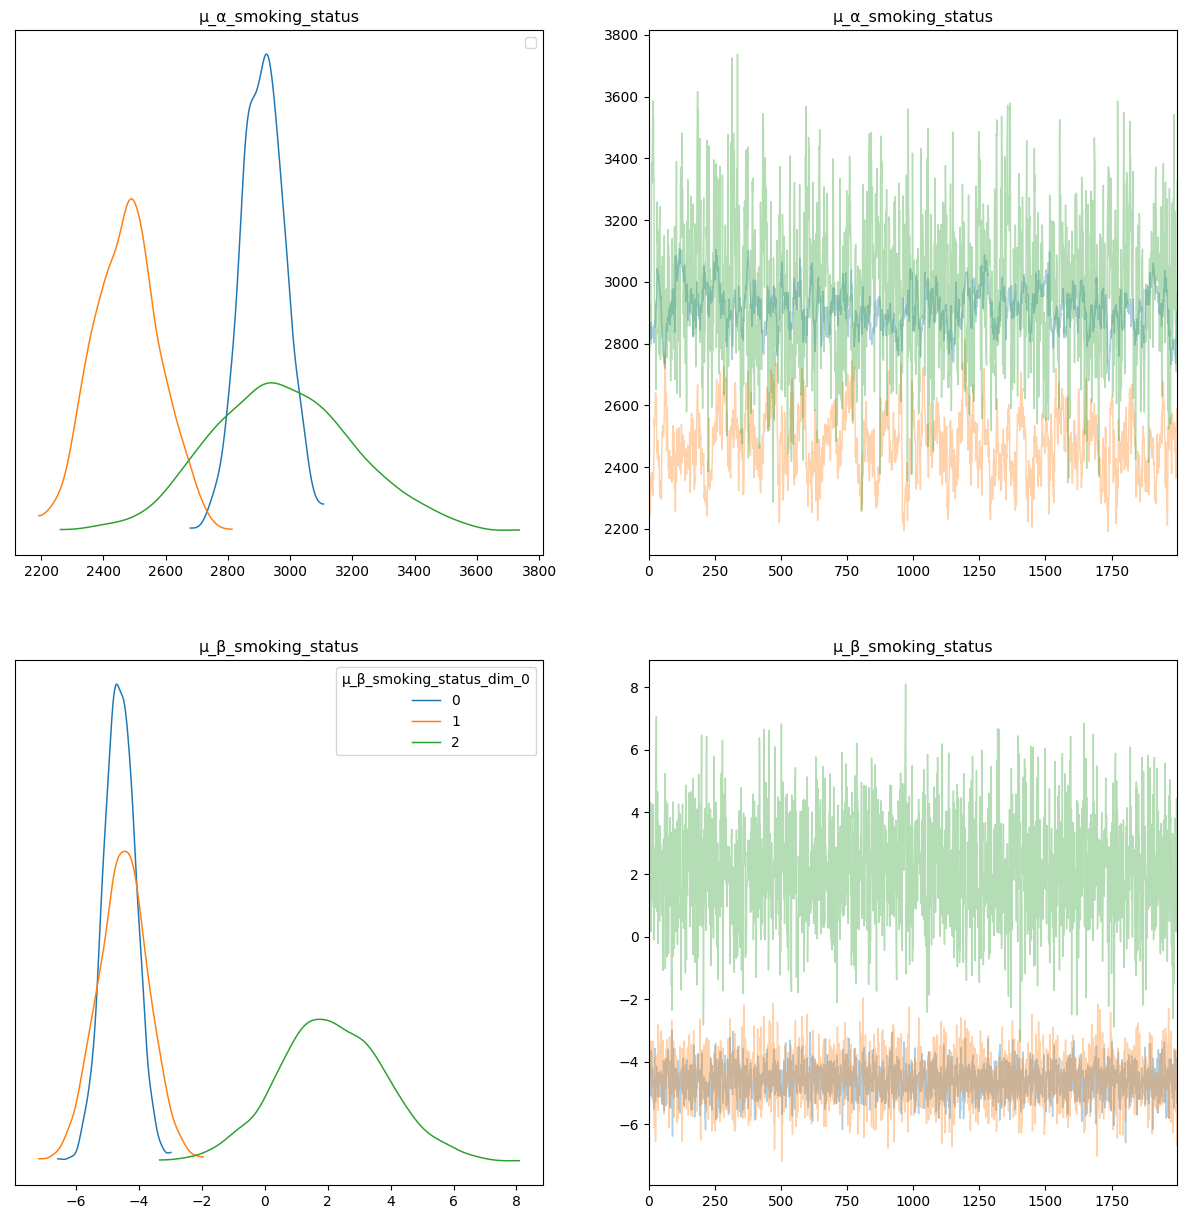

In [ ]:
axes = az.plot_trace(
    data,
    var_names=["μ_α_smoking_status", "μ_β_smoking_status"],
    legend=True,
    compact=True,
    figsize=(15, 15),
)
# The legend handles were not working for the first plot
axes[0, 0].legend();

### Interpret smoking status model parameters

The model parameters for each smoking status show interesting results, especially for trend, `μ_β_smoking_status`.  In the trace plots above and summary table below the trend for current smokers, `μ_β_smoking_status[0]`, has a positive mean, whereas the trend for patients that are ex-smokers and those that have never smoked are negative, `μ_β_smoking_status[1]` and `μ_β_smoking_status[2]`.

In [ ]:
trace = az.from_numpyro(mcmc)
az.summary(
    trace,
    var_names=["μ_α_global", "μ_β_global", "μ_α_smoking_status", "μ_β_smoking_status"],
)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean       sd    hdi_3%   hdi_97%  mcse_mean  \
μ_α_global             1674.512  314.217  1100.978  2260.562      8.915   
μ_β_global               -1.233    2.106    -5.175     2.851      0.051   
μ_α_smoking_status[0]  2914.509   69.577  2788.845  3049.092      6.765   
μ_α_smoking_status[1]  2474.959  105.133  2288.874  2677.789      8.460   
μ_α_smoking_status[2]  2975.848  228.898  2578.478  3430.369     10.374   
μ_β_smoking_status[0]    -4.623    0.499    -5.557    -3.681      0.014   
μ_β_smoking_status[1]    -4.512    0.791    -6.083    -3.123      0.021   
μ_β_smoking_status[2]     2.129    1.687    -1.137     5.252      0.043   

                       mcse_sd  ess_bulk  ess_tail  r_hat  
μ_α_global               6.306    1240.0    1279.0    NaN  
μ_β_global               0.045    1698.0    1364.0    NaN  
μ_α_smoking_status[0]    4.808     106.0     156.0    NaN  
μ_α_smoking_status[1]    6.009     156.0     297.0    NaN  
μ_α_smoking_status[2]    7.381     490.0     739.0    NaN  
μ_β_smoking_status[0]    0.010    1334.0    1617.0    NaN  
μ_β_smoking_status[1]    0.015    1369.0    1661.0    NaN  
μ_β_smoking_status[2]    0.031    1525.0    1433.0    NaN

Let's look at these curves for individual patients to help interpret these model results.

### 5.2. Visualizing FVC decline curves for some patients

In [ ]:
patient_code = pred_template["patient_code"].values
Weeks = pred_template["Weeks"].values
predictive = Predictive(
    reparam_model_smoking_hierarchy, posterior_samples, return_sites=["σ", "obs"]
)
samples_predictive = predictive(
    random.PRNGKey(0), patient_code, Weeks, map_patient_to_smoking_status, None
)

In [ ]:
df = pred_template.copy()
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})
df.head()

Patient  patient_code  Weeks     FVC_pred       sigma  \
0  ID00007637202177411956430             0    -12  2231.286133  160.407776   
1  ID00007637202177411956430             0    -11  2220.803711  158.352692   
2  ID00007637202177411956430             0    -10  2223.590088  152.948715   
3  ID00007637202177411956430             0     -9  2219.156006  153.727097   
4  ID00007637202177411956430             0     -8  2212.966553  157.031403   

       FVC_inf      FVC_sup  FVC_true  
0  2070.878418  2391.693848       NaN  
1  2062.450928  2379.156494       NaN  
2  2070.641357  2376.538818       NaN  
3  2065.428955  2372.883057       NaN  
4  2055.935059  2369.998047       NaN

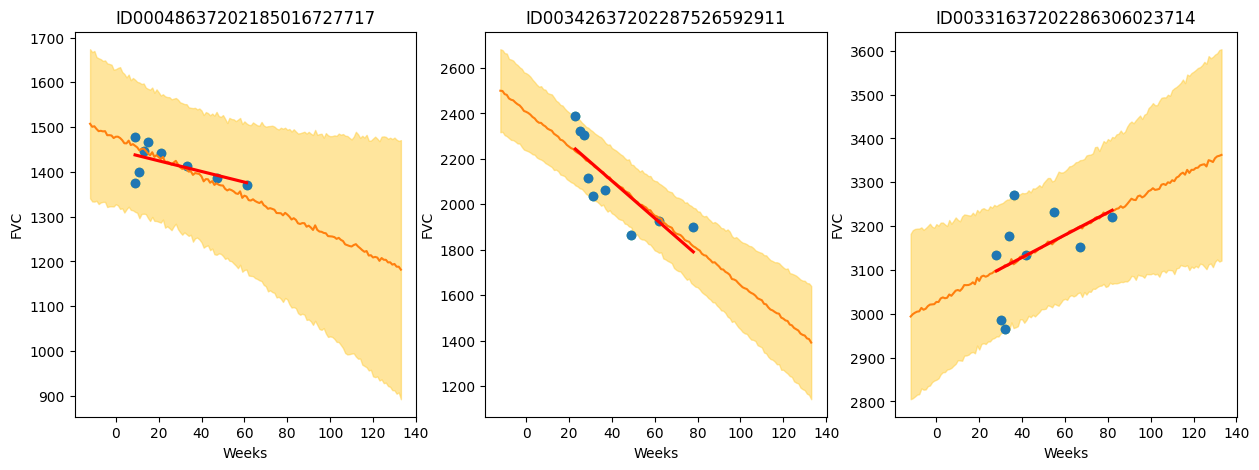

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
chart_patient_with_predictions("ID00048637202185016727717", axes[0])  # Never smoked
chart_patient_with_predictions("ID00342637202287526592911", axes[1])  # Ex-smoker
chart_patient_with_predictions("ID00331637202286306023714", axes[2])  # Currently smokes

### Review patients that currently smoke

By plotting each patient with the smoking status "Currently smokes", we see some patients with a clear positive trend and others without a clear trend or negative trend.  The trend lines are less overfit than the unpooled trend lines and show relatively large uncertainty in the slope and intercept.  Depending on the model use case, we could proceed in different ways:

- If we just wanted to get an understanding of different attributes as they relate to patient's FVC over time, we could stop here with an understanding that current smokers might have an increase in FVC over time when being monitored for Pulmonary Fibrosis.  We might hypothesize causes for this observation to design a new experiment to test that hypothesis.
- If we wanted to develop a model that generates predictions used to treat patients, then we will want to make sure we are not overfitting so that we can trust the model with new patients.  We might adjust model parameters to shrink the "Currently smokes" group model parameters to be closer to global parameters or even combine the group with "Ex-smokers".  We could look into collecting more data for current smokers to help ensure the model is not overfitting.

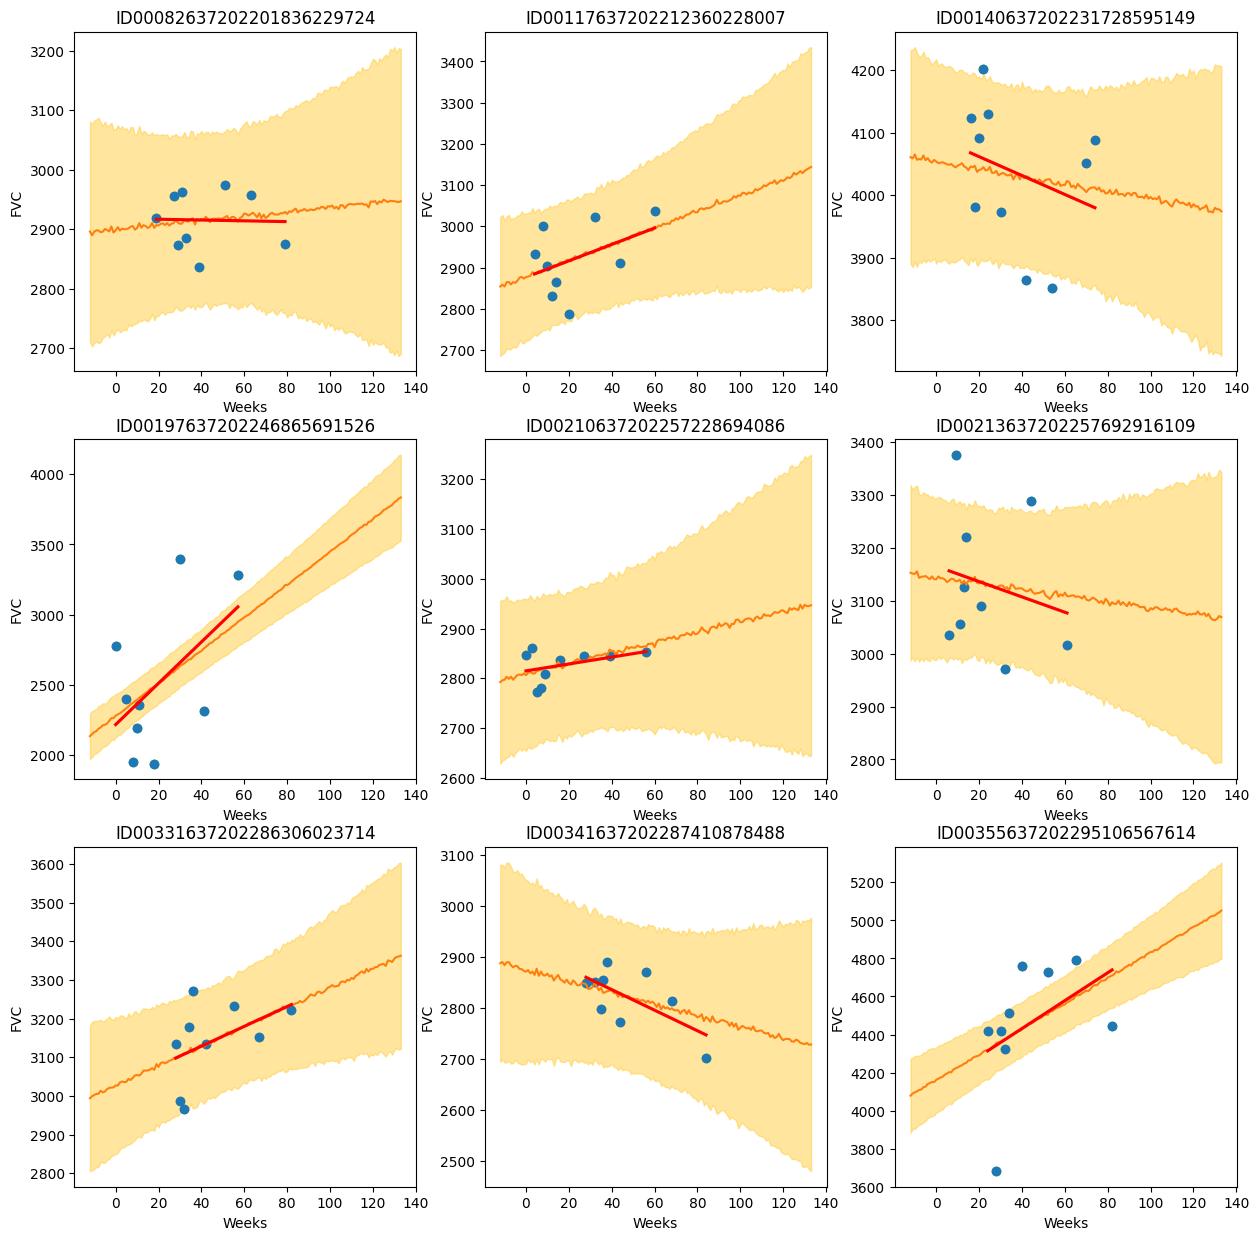

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, patient in enumerate(
    train[train["SmokingStatus"] == "Currently smokes"]["Patient"].unique()
):
    chart_patient_with_predictions(patient, axes.flatten()[i])

### 5.3 Modified Laplace Log Likelihood and RMSE for model with Smoking Status Level

We calculate the metrics for the updated model and compare to the original model.

In [ ]:
y = df.dropna()
rmse = ((y["FVC_pred"] - y["FVC_true"]) ** 2).mean() ** (1 / 2)
print(f"RMSE: {rmse:.1f} ml")

sigma_c = y["sigma"].values
sigma_c[sigma_c < 70] = 70
delta = (y["FVC_pred"] - y["FVC_true"]).abs()
delta[delta > 1000] = 1000
lll = -np.sqrt(2) * delta / sigma_c - np.log(np.sqrt(2) * sigma_c)
print(f"Laplace Log Likelihood: {lll.mean():.4f}")

RMSE: 122.6 ml
Laplace Log Likelihood: -6.1430


Both the Laplace Log Likelihood and RMSE show slightly worse performance for the smoking status model.  We've learned that adding this hierarchy level as-is did not improve model performance, but we did find some interested results from the smoking status level that might be worth investigating.  In addition, we might try to adjust priors or trying a different level (e.g. gender) to improve model performance.